# Анализ динамики цен на лечение в медицинской клинике

**Цель исследования** - провести анализ изменения цены лечения в 2022 году относительно 2021 года в медицинской клинике и определить ключевые драйверы изменения цены лечения. 

**Ход исследования**

Данные представлены в файле `data_test_task_2022.xlsx` ([**ссылка на сырые данные**](https://disk.yandex.ru/i/0SQwTeTujLhFnw)) - это срез истории оказанных медицинских услуг, сожержащих информацию дате, наименовании и стоимости услуг, а также основную информацию о клиенте. Данные будут предобработаны - проведётся проверка на наличие пропущенных значений и дубликатов, корректность типа хранимых данных, будет установлена необходимость в добавлении дополнительных столбцов. Затем будет проведён исследовательский анализ, целью которого станет поиск характерных признаков, оказывающих влияние на стоимость услуг клиники, а также возможные признаки для сегментации. На основе выводов будут сформированы показатели, которые будут использованы для проверки следующих гипотез:

* Средняя стоимость обслуживания изменилась из-за изменения интенсивности лечения пациентов
* Средняя стоимость обслуживания пациентов изменилась из-за изменения цен на услуги
* Средняя стоимость обслуживания пациентов изменилась из-за изменения поло-возрастной структуры обслуживаемых пациентов

Результаты проверки гипотез станут основой для формирования общего выводы.

Таким образом, исследование будет разбито на следующие этапы:

1. [**Обзор и предобработка данных**](#1)
2. [**Исследовательский анализ данных**](#2)
3. [**Проверка гипотез**](#3)
4. [**Общий вывод**](#4)

Для выполнения проекта будет использованы следующие инструменты:

- **Предобработка/исследовательский анализ** - библиотеки для анализа и визуализации (pandas/numpy/matplotlib/seaborn)
- **Проверка гипотез** - статистический пакет функций scipy, алгоритмы кластеризации машинного обучения (scikit-learn)

<a id='1'></a>
## Обзор и предобработка данных

In [1]:
# импортируем библиотеки для работы с данными

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt

# импортируем модули для проверки гипотез

from scipy import stats as st
import math as mth
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# настройки отображения

pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
sns.set_style('darkgrid')
plt.rcParams.update({'axes.labelsize': 12,'axes.titlesize': 16})
plt.rcParams['figure.figsize'] = [15, 5]

# путь к датасету

import os
os.chdir('C:\\Users\\dmitr\\GitHub\\Practicum-Data-Analysis\\datasets')

In [2]:
# загружаем данные, выводим общую информацию и 10 случайных строк

data = pd.read_excel('data_test_task_2022.xlsx')

data.info()
data.sample(10, random_state=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_id             85369 non-null  int64  
 1   service_date          85369 non-null  object 
 2   service_name          85369 non-null  object 
 3   service_amount        85369 non-null  int64  
 4   service_number        85369 non-null  int64  
 5   insured               85369 non-null  int64  
 6   sex_id                85348 non-null  float64
 7   age_for_service_date  85369 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 5.2+ MB


,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
48585,32112407203,2022-02-19,Лазеротерапия (1 сеанс),960,1,651954,2.00,30
62499,32511008103,2022-04-30,"Прием аллерголога, первичный",1540,1,935418,1.00,40
57641,32327210003,2022-03-13,Классический лечебный массаж спины,1530,1,780712,1.00,27
73029,32801027803,2022-06-06,Классический лечебный массаж спины,1530,1,634743,2.00,38
19054,30961840603,2021-06-14,Гинекологический мазок,525,1,634833,2.00,36
22976,31249251003,2021-08-11,Прием повторный,1313,1,652267,2.00,37
6736,30489531703,2021-03-20,Общий анализ кала,693,1,512527,2.00,23
69686,32631624203,2022-05-27,"Спирография с бронхолитиком (беротек, вентолин)",1320,1,548786,2.00,34
4644,30489322503,2021-03-23,АСТ (аспартатаминотрансфераза),242,1,512581,2.00,48
54383,32326881103,2022-03-24,Взятие крови из периферической вены,170,1,176395,1.00,43


___
Таблица содержит **85,369** строк и **8** столбцов.

Описание данных из документации:

- `record_id`- уникальный идентификатор строки данных
- `service_date` - дата оказания медицинской услуги
- `service_name` - наименование медицинской услуги
- `service_number` - количество услуг
- `service_amount` - сумма выплат (стоимость оказанных услуг в рублях)
- `insured` - уникальный идентификатор пациента
- `sex_id` - пол пациента
- `age_for_service_date` - возраст пациента

Для учёта при предобработке:

- даты оказания услуг представлены в виде текста, необходимо преобразование
- столбец с информации о поле пациента содержит пропущенные значения
- предположительно диапазоны значений позволят хранить числовые данные в форматах `int16/float16` вместо `int32/float32`, что значительно сохранит ресурсы используемой памяти
___

Рассмотрим каждый столбец по отдельности:

In [3]:
# перед предобработкой сохраним сырой датасет

original = data.copy()

# убедимся, что количество уникальных идентификаторов совпадает с размером таблицы

data['record_id'].unique().size == len(data)

True

Преобразуем даты в корректный формат и посмотрим на диапазон:

In [4]:
# преобразуем данные, выводим описательную статистику

data['service_date'] = pd.to_datetime(data['service_date'])
data['service_date'].describe(datetime_is_numeric=True)

count                            85369
mean     2021-12-02 19:38:31.794679808
min                2021-01-03 00:00:00
25%                2021-07-17 00:00:00
50%                2021-12-17 00:00:00
75%                2022-04-24 00:00:00
max                2022-08-31 00:00:00
Name: service_date, dtype: object

* Таблица содержит данные об оказанных услугах с **03-01-2021** по **31-08-2022**. Так как данные за 2022 год ограничены августом, выборки данных по датам при сравнении могут быть неравномерными, а потому не являтся репрезентативными.

Посмотрим на перечень предоставляемых услуг:

In [5]:
data['service_name'].value_counts()

Прием первичный                                    6058
Прием повторный                                    4477
Взятие крови из периферической вены                4215
Общий анализ крови (лейкоцитарная форм,, СОЭ)      3190
Магнитотерапия (1 сеанс)                           2838
                                                   ... 
Коагуляция при носовом кровотечении р/х ножом         1
Введение турунды с лекарственными формами в нос       1
Андростендион                                         1
МРТ локтевого сустава                                 1
Ренин                                                 1
Name: service_name, Length: 875, dtype: int64

* Таблица содержит данные об **875** уникальных медицинских услуг, самыми популярными из которых являются `Приём первичный`, `Приём повторный` и `Взятие крови из периферической вены`

Посмотрим на распределение количества оказанных услуг:

In [6]:
# считаем уникальные значения

data['service_number'].value_counts().sort_index()

1     83807
2      1373
3       135
4        26
5        10
6         1
7         4
11        1
12        2
13        5
14        2
15        1
16        2
Name: service_number, dtype: int64

В подавляющем большинстве случаев записи содержат данные об единичной услуге. На всякий случай проверим записи с большими значениями:

In [7]:
# выводим срез по количеству больше 5

data.query('service_number > 5')

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
9050,30620900003,2021-04-03,Постановка кожных аллергопроб (за 1 единицу),2772,12,512453,1.00,29
12519,30786052903,2021-05-01,Постановка кожных аллергопроб (за 1 единицу),2541,11,512572,2.00,35
12618,30786062803,2021-05-15,Постановка кожных аллергопроб (за 1 единицу),3003,13,363075,2.00,34
14404,30786241403,2021-05-15,Постановка кожных аллергопроб (за 1 единицу),3003,13,596505,1.00,33
31349,31485597303,2021-10-26,Постановка кожных аллергопроб (за 1 единицу),1680,7,716050,2.00,26
33344,31485798003,2021-10-29,Постановка кожных аллергопроб (за 1 единицу),1440,6,698613,2.00,40
36313,31680597403,2021-11-20,Постановка кожных аллергопроб (за 1 единицу),3840,16,544906,1.00,31
36853,31680651703,2021-11-02,Постановка кожных аллергопроб (за 1 единицу),1680,7,716108,1.00,27
37567,31680727103,2021-11-25,Постановка кожных аллергопроб (за 1 единицу),3840,16,734530,2.00,43
43755,31814239903,2021-12-10,Постановка кожных аллергопроб (за 1 единицу),1680,7,693347,2.00,30


Аномальных значений не обнаружено, подобная запись услуги оправдана её спецификой. Переходим к столбцу с ценами на услуги:

In [8]:
# выводим описательную статистику

data['service_amount'].describe()

count   85,369.00
mean     1,166.09
std        799.06
min        147.00
25%        550.00
50%      1,155.00
75%      1,530.00
max     26,999.00
Name: service_amount, dtype: float64

* Минимальная стоимость оказанных услуг составляет **147 рублей**, максимальная - **26,999 рублей**. В среднем стоимость оказанных медицинских услуг в клинике составляет **1,166 рублей**.

Добавим в таблицу столбец со стоимостью одной услуги:

In [9]:
data['service_price'] = (data['service_amount']/data['service_number']).astype('int32')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   record_id             85369 non-null  int64         
 1   service_date          85369 non-null  datetime64[ns]
 2   service_name          85369 non-null  object        
 3   service_amount        85369 non-null  int64         
 4   service_number        85369 non-null  int64         
 5   insured               85369 non-null  int64         
 6   sex_id                85348 non-null  float64       
 7   age_for_service_date  85369 non-null  int64         
 8   service_price         85369 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(5), object(1)
memory usage: 5.5+ MB


Изучим уникальные идентификаторы пациентов:

In [11]:
data['insured'].astype('object').describe()

count      85369
unique      4488
top       418193
freq         303
Name: insured, dtype: int64

* Таблица содержит данные об **4,488** уникальных клиентах. Чаще всего к услугам клиники прибегает клиент с идентификатором `441893`

Изучим распределение пациентов по полу:

In [12]:
# расчитаем доли распределения пациентов по полу

sex_distr = (
    (data['sex_id']
     .value_counts()/len(data))
    .sort_index()
    .to_frame()
    .rename(columns=dict(sex_id='sex_distribution'))
)

# расчитаем количество пропусков

na_share = round(
    data['sex_id'].isna().sum()/len(data), 4
)

# выводим результат

display(sex_distr)
print(f'missing values: {na_share}%')


,sex_distribution
1.00,0.38
2.00,0.62


missing values: 0.0002%


* Примерное соотношение пациентов по полу составляет **40/60**.

Так как количество пропущенных значений составляет менее 1% от общих данных, их можно заполнить медианным значением без ущерба для результатов исследования:

In [13]:
# заполняем пропуски

data['sex_id'] = (
    data['sex_id']
    .fillna(data['sex_id'].median())
    .astype('int64')
)

Последний столбец - возраст клиентов:

In [14]:
# выводим описательную статистику

data['age_for_service_date'].describe()

count   85,369.00
mean        33.85
std         12.14
min          0.00
25%         27.00
50%         34.00
75%         41.00
max         83.00
Name: age_for_service_date, dtype: float64

* Диапазон возраста клиентов - от **0** до **83**. Средний возраст пациента клиники составляет **34 года**. Такой широкий разброс даёт возможность для сегментации клиентов по возрасту.

Проверим данные целиком на наличие явных дубликатов: 

In [15]:
# убедимся в отсутствии задублированных строк

data.duplicated().sum() == 0

True

Поменяем типы данных для экономии памяти:

In [16]:
# напишем цикл, преобразующий целочисленные данные

col = data.columns.to_list()

for val in range(len(col)):
    if data[col[val]].dtype == 'int64':
        data[col[val]] = data[col[val]].astype('int32')
        
# сравним объём используемой памяти

memory_usage_diff = round(
    data.memory_usage().sum()/original.memory_usage().sum()*100, 2
)

print(f'memory usage reduced by {memory_usage_diff}%')

memory usage reduced by 68.75%


In [17]:
# выводим общую информацию об обработанном датасете

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   record_id             85369 non-null  int32         
 1   service_date          85369 non-null  datetime64[ns]
 2   service_name          85369 non-null  object        
 3   service_amount        85369 non-null  int32         
 4   service_number        85369 non-null  int32         
 5   insured               85369 non-null  int32         
 6   sex_id                85369 non-null  int32         
 7   age_for_service_date  85369 non-null  int32         
 8   service_price         85369 non-null  int32         
dtypes: datetime64[ns](1), int32(7), object(1)
memory usage: 3.6+ MB


### Итоги

Обработанные данные представлены в виде таблицы, содержащей **85,369** строк и **9** столбцов. Был провёден обзор таблицы и описание данных из документации заказчика. В ходе предобработке изучены с точки зрения общих распределений значений и наличия дубликатов, пропущенные значения были обработаны. Данные были приведены к корректным типам хранения, что позволило уменьшить объём ресурсов используемой памяти на **69%**.

В ходе предобработки были сделаны следующие выводы:

* Таблица содержит данные об оказанных услугах с **03-01-2021** по **31-08-2022**. Так как данные за 2022 год ограничены августом, выборки данных по датам при сравнении могут быть неравномерными, а потому не являтся репрезентативными.


* В данных содержатся сведения об **875** уникальных медицинских услуг, самыми популярными из которых являются `Приём первичный`, `Приём повторный` и `Взятие крови из периферической вены`


* Минимальная стоимость оказанных услуг составляет **147 рублей**, максимальная - **26,999 рублей**. В среднем стоимость оказанных медицинских услуг в клинике составляет **1,166 рублей**.


* В данных представлены **4,488** уникальных клиентов. Чаще всего к услугам клиники прибегает клиент с идентификатором `441893`


* Примерное соотношение пациентов по полу составляет **40/60**.


* Диапазон возраста клиентов - от **0** до **83**. Средний возраст пациента клиники составляет **34 года**. Такой широкий разброс даёт возможность для сегментации клиентов по возрасту.

<a id='2'></a>
## Исследовательский анализ данных

Так как все основные гипотезы исследования завязаны на динамике стоимости лечения пацентов клинике, основным источником для исследования станет датасет, сгруппированный по уникальным идентификатором клиентов, а затем разделённый на 2021 и 2022 год. Основными группами параметров для рассмотрения станут **общая сумма затрат**, **количество оказанных услуг и средняя стоимость одной услуги**, **количество уникальных пациентов, их средний возраст и соотношение по полу**.  В ходе исследования сначала будет изучено распределение основных значений в динамике дат предоставления услуг, после чего данные будут изучены в разрезе клиентов, и в итоге - сопоставлены по годам.

Таким образом, исследовательский анализ будет разделён на следующие этапы:

1. [**Динамика использования услуг клиники**](#2.1)
2. [**Анализ пациентов**](#2.2)
3. [**Сравнение данных за 2021 и 2022 годы**](#2.3)
4. [**Вывод**](#2.4)

<a id='2.1'></a>
### Динамика использования услуг клиники
Сгруппируем данные по месяцу предоставления услуги и изучим распределение параметров:

In [18]:
# создадим список параметров и соответствующих аггрегирующих функций

params = {'service_amount':'sum', 
          'service_number':'sum',
          'insured':'nunique',
          'age_for_service_date':'mean'}

# столбец с месяцем оказания услуги

data['service_month'] = data['service_date'].dt.strftime('%Y-%m')

# расчитаем распределение по полу

sex_distr = (
    data[['sex_id', 'service_month', 'record_id']]
    .pivot_table(index='service_month', 
                 columns='sex_id', 
                 aggfunc='count')
    .reset_index()
    .droplevel(0, axis=1)
    .rename(columns={'':'service_month', 
                     1:'sex_1', 2:'sex_2'})
)

total = sex_distr['sex_1'] + sex_distr['sex_2']
sex_distr['sex_1'] = sex_distr['sex_1']/total
sex_distr['sex_2'] = sex_distr['sex_2']/total

# группируем данные в единый датафрейм

eda_months = (
    data
    .pivot_table(index='service_month', aggfunc=params)
    .reset_index()
    .merge(sex_distr, on='service_month')
    .rename(columns={'service_month':'month',
                     'age_for_service_date':'mean_age',
                     'insured':'unique_patients',
                     'service_amount':'total_costs',
                     'service_number':'services_provided'})
    .reindex(columns=['month', 
                      'unique_patients', 
                      'mean_age', 
                      'sex_1', 
                      'sex_2', 
                      'services_provided', 
                      'total_costs'])
)

# расчитываем дополнительные показатели

eda_months['costs_per_service'] = (
    eda_months['total_costs']/eda_months['services_provided']
)

eda_months['costs_per_patient'] = (
    eda_months['total_costs']/eda_months['unique_patients']
)

# выводим финальную таблицу

eda_months.info()
display(eda_months.describe())
eda_months

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   month              20 non-null     object 
 1   unique_patients    20 non-null     int64  
 2   mean_age           20 non-null     float64
 3   sex_1              20 non-null     float64
 4   sex_2              20 non-null     float64
 5   services_provided  20 non-null     int32  
 6   total_costs        20 non-null     int32  
 7   costs_per_service  20 non-null     float64
 8   costs_per_patient  20 non-null     float64
dtypes: float64(5), int32(2), int64(1), object(1)
memory usage: 1.4+ KB


,unique_patients,mean_age,sex_1,sex_2,services_provided,total_costs,costs_per_service,costs_per_patient
count,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00
mean,536.80,33.85,0.38,0.62,"4,366.05","4,977,416.65","1,133.72","9,189.24"
std,144.27,0.89,0.04,0.04,"1,238.75","1,528,294.78",50.14,755.19
min,286.00,31.77,0.32,0.54,"2,071.00","2,265,931.00","1,040.88","7,699.43"
25%,446.75,33.52,0.35,0.59,"3,857.75","4,206,045.50","1,099.70","8,769.78"
50%,547.00,33.94,0.38,0.62,"4,214.50","4,765,094.50","1,132.71","9,080.78"
75%,603.50,34.47,0.41,0.65,"4,978.75","6,101,809.50","1,169.00","9,709.79"
max,802.00,35.52,0.46,0.68,"6,843.00","8,035,080.00","1,264.03","10,396.75"


,month,unique_patients,mean_age,sex_1,sex_2,services_provided,total_costs,costs_per_service,costs_per_patient
0,2021-01,286,33.94,0.36,0.64,2071,2265931,"1,094.12","7,922.84"
1,2021-02,309,33.89,0.34,0.66,2155,2379125,"1,104.00","7,699.43"
2,2021-03,446,32.85,0.36,0.64,3773,3927248,"1,040.88","8,805.49"
3,2021-04,467,33.64,0.37,0.63,3984,4380487,"1,099.52","9,380.06"
4,2021-05,469,34.12,0.33,0.67,3915,4298978,"1,098.08","9,166.26"
5,2021-06,435,34.45,0.40,0.60,3988,4522585,"1,134.05","10,396.75"
6,2021-07,447,34.53,0.45,0.55,3632,3872209,"1,066.14","8,662.66"
7,2021-08,488,33.19,0.42,0.58,3886,4310989,"1,109.36","8,833.99"
8,2021-09,559,31.77,0.39,0.61,4349,4782859,"1,099.76","8,556.10"
9,2021-10,591,32.21,0.41,0.59,5161,6063580,"1,174.88","10,259.86"


___
Полученная таблица содержит **20 строк** и **9 столбцов**. На каждый месяц расчитаны следующие показатели - среднее количество пациентов, средний возраст и распределение по полу, количество предоставленных услуг, общая сумма затрат, средняя стоимость одной услуги и средняя сумма на одного уникального пациента. 
___

* В среднем на каждый месяц работы клиники приходится **536** уникальных пациентов. Среднее число предоставляемых услуг - **4,366**, а общая сумма затрат составляет **4,977,417 рублей**. Средняя стоимость услуги составляет **1,134 рубля**, одному клиенту в среднем предоставляются услуги на **9,205 рублей**.

Сначала изучим общую корреляцию значений таблицы между собой:

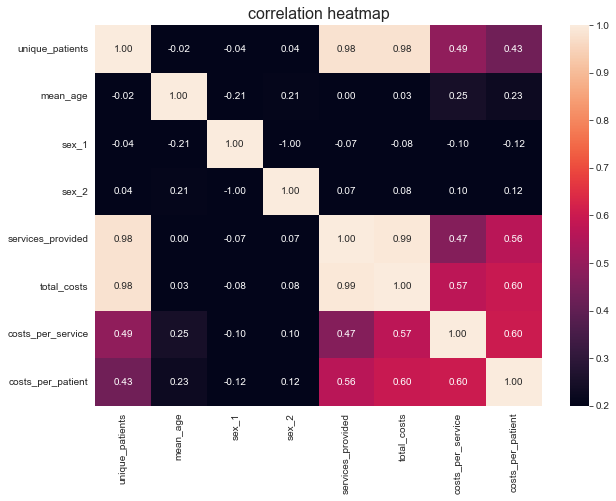

In [19]:
# визуализируем коэффициенты корреляции значений таблицы

plt.figure(figsize=(10, 7))

sns.heatmap(eda_months.corr(), 
            fmt='.2f', 
            annot=True, 
            vmin=0.2)

plt.title('correlation heatmap')
plt.show()

* Коэффициенты корреляции между сочетаниями параметров количества уникальных посетителей, количества предоставленных услуг и общей сумме затрат достигают максимальных значений. Это может указывать на незначительное влияние остальных параметров на среднюю сумму затрат, в частности поло-возрастной структуры пациентов или увеличением стоимости отдельных услуг.

Рассмотрим подробнее динамику количества пациентов и их половозрастную структуру:

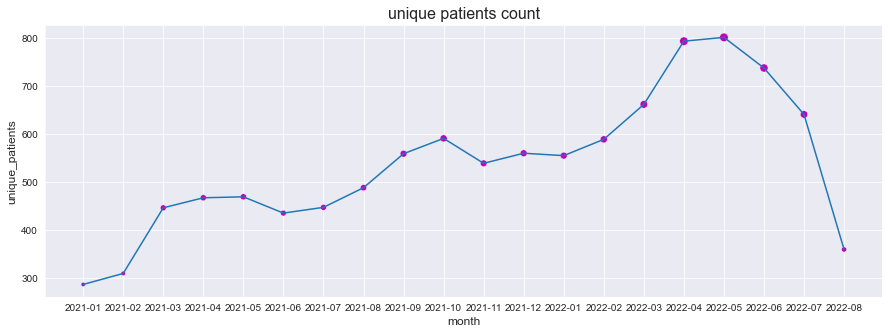

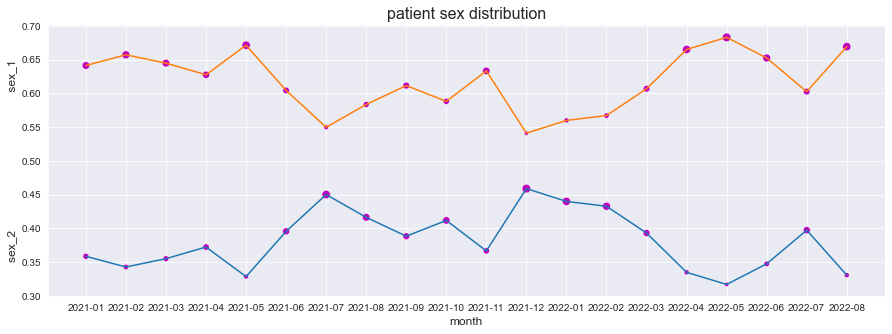

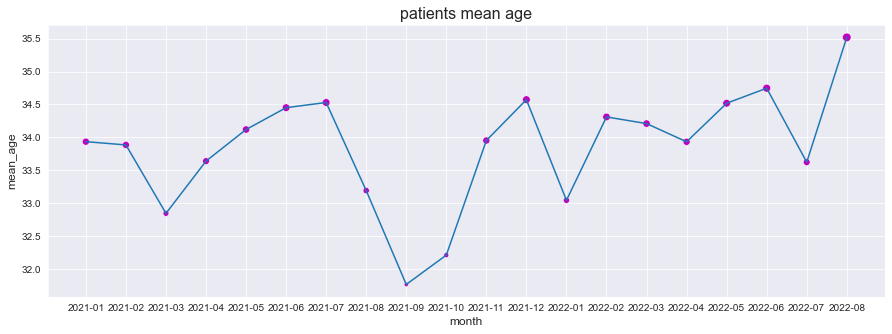

In [20]:
# напишем функцию для визуализации распределений

def distr_plot(y, title, y_2=None):
    
    sns.lineplot(data=eda_months, 
                 x='month', 
                 y=y)

    sns.scatterplot(data=eda_months, 
                    x='month', 
                    y=y, 
                    color='m', 
                    size=y, 
                    legend=False)
    if y_2 == None:

        plt.title(title)
        plt.show()
        
    else:
        sns.lineplot(data=eda_months, 
                     x='month', 
                     y=y_2)

        sns.scatterplot(data=eda_months, 
                        x='month', 
                        y=y_2, 
                        color='m', 
                        size=y_2, 
                        legend=False)
        plt.title(title)
        plt.show()
    

# выводим количество уникальных пациентов
    
distr_plot('unique_patients', 'unique patients count')

# выводим распределение по полу

plt.ylabel('sex_2                                         sex_1')
distr_plot('sex_1', 'patient sex distribution', 'sex_2')

# выводим средний возраст пациентов

distr_plot('mean_age', 'patients mean age')

___

* Количество уникальных пациентов в месяц стабильно растёт на протяжении всего рассматриваемого периода, после чего происходит резкий спад в августе 2022-го года. Возможно резкое падение обусловлено недостатком данных за этот период. Наибольшое число пациентов призодится на апрель-май 2022-го года - около **800** уникальных пациентов.


* Распределение пациентов по полу имеет неравномерную структуру на протяжении всего периода. Самая очевидная закономерность - самый большой разрыв приходится на май как 2021-го, так и 2022-го года. Наибольшее равенство полов наблюдается в декабре 2021-го.


* Описать динамику среднего возраста пациента можно описать следующим образом: рассматриваемый период начинается со значения, близкому к общему среднему, в феврале 2021-го происходи спад, который сменяеться стабильным ростом вплоть до июля. Затем на протяжении следующих двух месяцев происходит резкий спад, достигая минимального значения в сентября (**возраст < 31 года**), после чего график снова растёт вплоть до конца 2021-го года. В начале 2022 происходит небольшой спад, затем также начинается стабильный рост, небольшой провал в июле, а в конце - резкий скачок, достигающий пика всего рассматриваемого периода (**возраст ~ 35.5 лет**).

В целом на данном этапе данных недостаточно для однозначных выводов по динамике изменения поло-возрастной структуры пациентов - перед проверкой гипотез необходимо также проанализировать данные в разрезе уникальных пациентов.

___

Далее проанализируем изменение общей суммы затрат по месяцам:

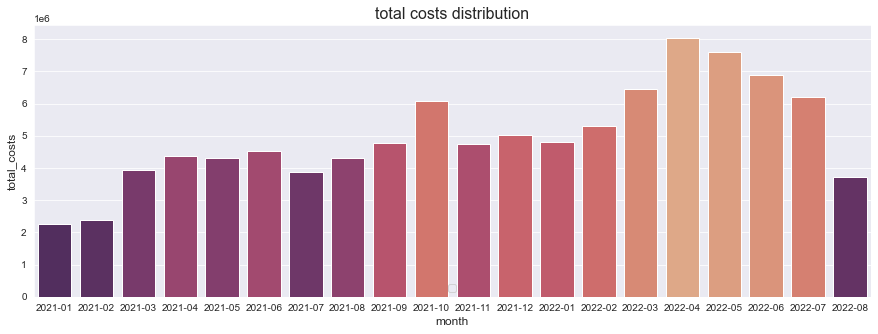

In [21]:
# визуализируем динамику затрат

sns.barplot(data=eda_months, 
            x='month', 
            y='total_costs', 
            hue='total_costs', 
            palette='flare_r', 
            dodge=False)

plt.title('total costs distribution')
plt.legend('')
plt.show()

* На протяжении всего рассматриваемого периода прослеживается тенденция роста общей суммы затрат на обслуживание клиентов, за исключением августа 2022 - возможно резкое падение также обусловлено недостатком данных, как и в случае количества уникальных пациентов. Пиком значения за 2021 год является октябрь, сумма составляет **~6,000,000 рублей**, а пиком 2022 года и всего рассматриваемого периода - апрель, сумма составляет **~8,000,000 рублей**. Несмотря на то, что пик уникальный посетителей приходится на май, общая сумма выше именно в апреле, что может говорить о большей популярности дорогостоящих процедур в этом месяце.

Напоследок изучим динамику количества предоставляемых услуг и сопутствующих параметров:

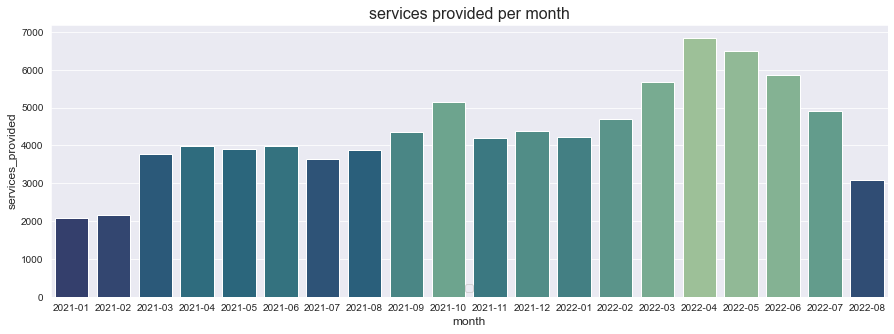

In [22]:
# визуализируем динамику количества оказанных услуг

sns.barplot(data=eda_months, 
            x='month', 
            y='services_provided', 
            hue='services_provided', 
            palette='crest_r', 
            dodge=False)

plt.title('services provided per month')
plt.legend('')
plt.show()

* Динамика количества оказанных услуг полностью идентична графику распределения общей выручки, что обусловлено их полностью положительной корреляции, выявленной ранее. Пиком значения за 2021 год  также является октябрь (**~5,000 услуг**), а пиком 2022 года и всего рассматриваемого периода - апрель (**~7,000 услуг**).

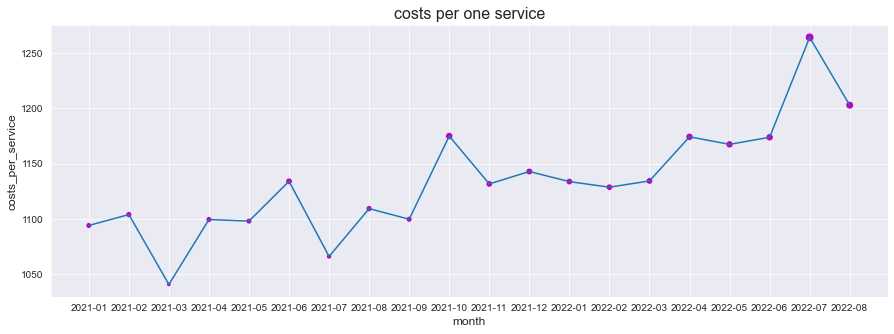

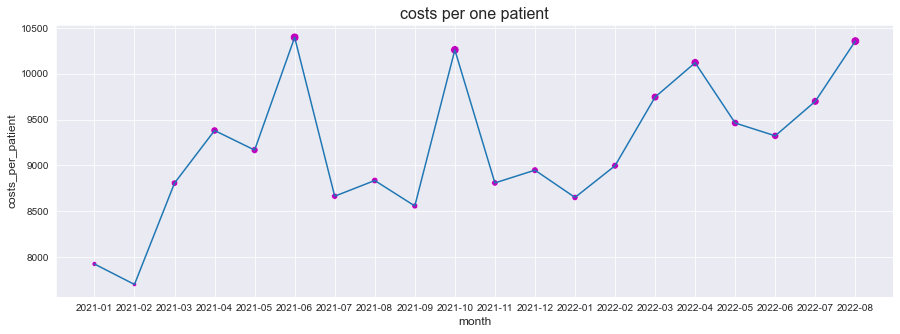

In [23]:
# визуализируем динамику изменения средней стоимости одной услуги
# и общих затрат на одного пациента

distr_plot('costs_per_service', 'costs per one service')
distr_plot('costs_per_patient', 'costs per one patient')

* График средней стоимости одной услуги показывает рост на протяжении всего рассматриваемого периода. Распределение значений в 2022-ом году становиться более равномерным, что может указывать на плановое повышение стоимости предоставляемых услуг. Пик стоимости одной услуги достигает в июле 2022-го года, под конец рассматриваемого периода (в средней более **1,250 рублей за  услугу**)


* Форма графика суммы затрат на одного клиента по своей форме не совпадает не с одним из других рассматриваемых параметров - пики значений приходятся на июнь и октябрь 2021-го года, что никак не коррелирует с пиками количества уникальных посетителей, количестве предоставляемых услуг и общей выручке. Это может указывать на популярность наиболее дорогостоящих услуг клиники в эти периоды.

<a id='2.2'></a>
### Анализ пациентов

Сгруппируем данные по уникальному идентификатору клиента и изучим распределение основных параметров:

In [24]:
# группируем данные

def group_by_patients(data):

    params = {'service_amount':'sum', 
              'service_number':'sum',
              'age_for_service_date':'median', 
              'sex_id':'median'}
    
    columns = {'service_amount':'total_costs', 
              'service_number':'services_used',
              'age_for_service_date':'age'}
    
    order = ['sex_id', 
             'age', 
             'services_used', 
             'total_costs']
    df = (
        data
        .pivot_table(index='insured', 
                     aggfunc=params)
        .rename(columns=columns)
        .reindex(columns=order)
    )
    
    df['costs_per_service'] = (
        df['total_costs']/df['services_used']
    )
    
    return round(df)

# выводим результат

eda_patients = group_by_patients(data)

eda_patients.info()
display(eda_patients.describe())
eda_patients

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4488 entries, 125073 to 1306795
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex_id             4488 non-null   int32  
 1   age                4488 non-null   float64
 2   services_used      4488 non-null   int32  
 3   total_costs        4488 non-null   int32  
 4   costs_per_service  4488 non-null   float64
dtypes: float64(2), int32(3)
memory usage: 157.8 KB


,sex_id,age,services_used,total_costs,costs_per_service
count,"4,488.00","4,488.00","4,488.00","4,488.00","4,488.00"
mean,1.57,31.75,19.46,"22,181.00","1,245.23"
std,0.50,12.79,25.00,"29,327.45",452.45
min,1.00,0.00,1.00,360.00,277.00
25%,1.00,26.00,3.00,"4,258.25",983.00
50%,2.00,33.00,10.00,"11,003.50","1,160.50"
75%,2.00,39.00,26.00,"28,671.00","1,470.00"
max,2.00,83.00,305.00,"361,352.00","9,450.00"


,sex_id,age,services_used,total_costs,costs_per_service
insured,,,,,
125073,2,66.00,27,33080,"1,225.00"
125094,2,44.00,20,27519,"1,376.00"
125404,1,26.00,1,1470,"1,470.00"
139315,1,25.00,3,3300,"1,100.00"
139539,2,42.00,56,75239,"1,344.00"
...,...,...,...,...,...
1306765,2,32.00,12,15412,"1,284.00"
1306768,2,22.00,36,34237,951.00
1306775,2,37.00,34,49361,"1,452.00"


___
Полученная таблица содержит **4,488 строк** и **5 столбцов**. На каждого пациента приведены следующие показатели - пол, возраст, количество предоставленных услуг, общая сумма затрат на услуги, средние затраты на одну услугу.
___

* В среднем каждый пациент за рассматриваемый период получает **19** медицинских услуг общей стомостью **22,181 рубль**, средняя стоимость услуги - **1, 245 рублей**. Средний возраст пациента - **32 года**, соотношение полов в разрезе пациентов сохраняется на уровне **60/40**.


* Количество предоставленных услуг и общая сумма затрат характерны высоким стандартным отклонением, многократно превыщающим медиану - это указывает на большое количество аномально высоких значений внутри этих показателей. 

Изучим корреляцию параметров:

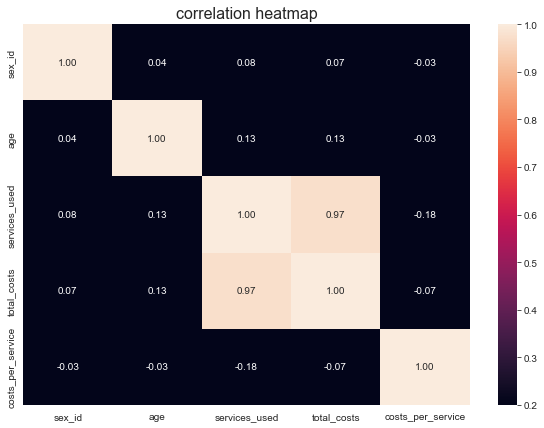

In [25]:
# визуализируем коэффициенты корреляции значений таблицы

plt.figure(figsize=(10, 7))

sns.heatmap(eda_patients.corr(), 
            fmt='.2f', 
            annot=True, 
            vmin=0.2)
plt.title('correlation heatmap')
plt.show()

* В срезе по уникальным клиентам сохраняется максимальная положительная корреляция между количеством полученных услуг и общей суммой затрат.

Распределение пациентов по полу уже известно - используем этот параметр как фильтр для изучения остальных признаков:

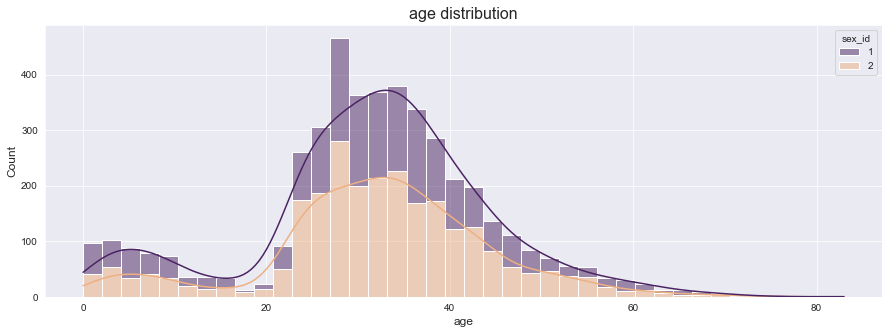

In [26]:
# напишем функцию для визуализации распределения параметров

def pop_overview(par, bins=100, 
                 data=eda_patients, 
                 ax=None, palette='flare_r'):

    sns.histplot(data=data, 
                 x=par, 
                 hue='sex_id', 
                 palette=palette, 
                 kde=True, 
                 multiple='stack',
                 bins=bins, ax=ax)
    
    plt.title(par + ' distribution')

# визуализируем распределение по возрасту

pop_overview('age', 40)

* Форма распределения возрастов клиентов в разрезе пола в целом не отличается - в обоих случаях наблюдается просадка в районе 20 лет (возможно обусловлено тем, что в подростковом возрасте клиенты не часто прибегают к медицинской помощи), большая часть пациентов представлена диапазоном от 20 до 40 лет. В возрасте около 30 лет происходит резкий скачок количества пациентов, достигающий пика для обоих полов.

Далее изучим количество полученных услуг и сумму затрат. Так как при обзоре таблицы было выявлено большое количество аномально высоких значений, ограничим график визуализации этих параметров значением 90%:

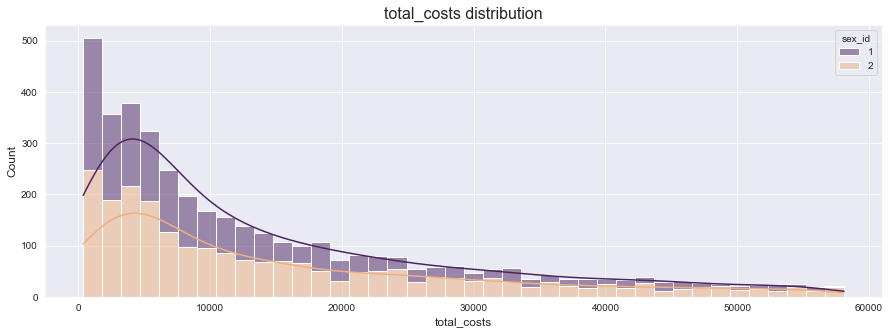

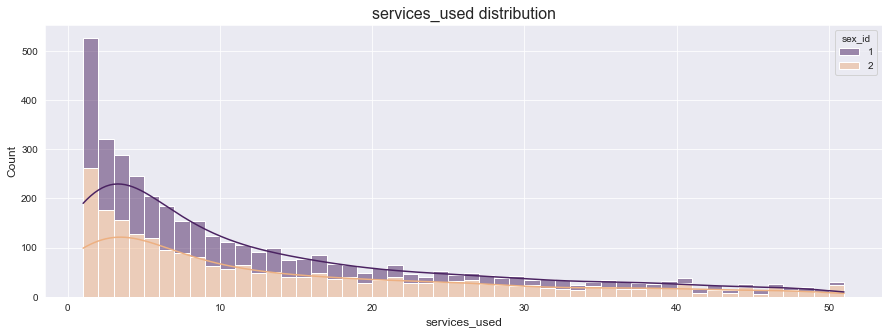

In [27]:
# визуализируем распределение по общей стоимости услуг

costs_limit = np.percentile(eda_patients['total_costs'], 90)

pop_overview('total_costs', 40, eda_patients.query('total_costs <= @costs_limit'))
plt.show()

# визуализируем распределение общего количества полученных услуг

services_limit = np.percentile(eda_patients['services_used'], 90)

pop_overview('services_used', 50, eda_patients.query('services_used <= @services_limit'))
plt.show()

* Распределение общей суммы затрат и количества использованных услуг ожидаемо схоже - это подкрепляется их высоким коэффициентом корреляции. Для абсолютного большинства клиентов характрно не более **20,000 рублей** общих затрат и не более **20 полученных услуг**, но при этом пик, с большим отрывом, приходится на **1,000 рублей** и **1 услугу**.  

Последний параметр - средняя стоимость одной услуги для каждого клиента. Так как в описательной статистике также можно было увидеть высокое максимально значение, ограничим визуализацию значениями до 5,000 рублей:

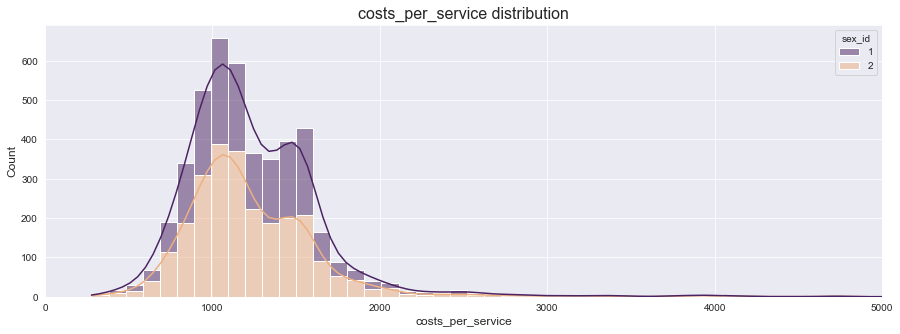

In [28]:
# визуализируем распределение

plt.xlim(0, 5000)
pop_overview('costs_per_service', 90)

* Абсолютное большинство пациентов имеют средний расход на одну услугу в диапазоне от **500 до 2,000 рублей**, количество остальных пациентов незначительно. Распределение имеет два пика - на уровне **1,000** и **1,500** рублей, между ними происходит незначительный провал. Форма распределения также не менятся в зависимости от пола пациента.

<a id='2.3'></a>
### Сравнение данных пациентов за 2021 и 2022 годы
Повторим все шаги предыдущего этапа, сопоставив данные за два года:

In [29]:
# фильруем данные

patients_2021 = group_by_patients(
    data[data['service_date'].dt.year == 2021]
)

patients_2022 = group_by_patients(
    data[data['service_date'].dt.year == 2022]
)

In [30]:
# выводим таблицу за 2021 год

patients_2021.info()
display(patients_2021.describe())
patients_2021

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2515 entries, 125073 to 774393
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex_id             2515 non-null   int32  
 1   age                2515 non-null   float64
 2   services_used      2515 non-null   int32  
 3   total_costs        2515 non-null   int32  
 4   costs_per_service  2515 non-null   float64
dtypes: float64(2), int32(3)
memory usage: 88.4 KB


,sex_id,age,services_used,total_costs,costs_per_service
count,"2,515.00","2,515.00","2,515.00","2,515.00","2,515.00"
mean,1.57,31.44,18.09,"20,104.04","1,218.12"
std,0.50,13.26,22.32,"26,106.31",479.72
min,1.00,0.00,1.00,360.00,277.00
25%,1.00,26.00,3.00,"3,964.50",948.00
50%,2.00,32.00,10.00,"10,419.00","1,130.00"
75%,2.00,39.00,25.00,"25,848.50","1,470.00"
max,2.00,83.00,239.00,"272,514.00","9,450.00"


,sex_id,age,services_used,total_costs,costs_per_service
insured,,,,,
125073,2,66.00,27,33080,"1,225.00"
125094,2,44.00,14,21139,"1,510.00"
125404,1,26.00,1,1470,"1,470.00"
139315,1,25.00,3,3300,"1,100.00"
139539,2,42.00,56,75239,"1,344.00"
...,...,...,...,...,...
774389,2,45.00,11,12140,"1,104.00"
774390,2,3.00,3,2490,830.00
774391,2,26.00,4,4030,"1,008.00"


* В целом показатели не отличаются от значений за весь рассматриваемый период, за исключенем количества полученных услуг (**18 услуг за 2021 против 19 за весь период**) и общей суммы затрат (**26,106 рублей** за 2021 и **22,181 рубль** в среднем за весь период, при том что средняя стоимость услуги остаётся на том же уровне). Это может указывать на большую попопулярность дорогостоящего лечения в 2021-ом году.

In [31]:
# выводим результат за 2022 год

patients_2022.info()
display(patients_2022.describe())
# patients_2022

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2757 entries, 125094 to 1306795
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex_id             2757 non-null   int32  
 1   age                2757 non-null   float64
 2   services_used      2757 non-null   int32  
 3   total_costs        2757 non-null   int32  
 4   costs_per_service  2757 non-null   float64
dtypes: float64(2), int32(3)
memory usage: 96.9 KB


,sex_id,age,services_used,total_costs,costs_per_service
count,"2,757.00","2,757.00","2,757.00","2,757.00","2,757.00"
mean,1.58,31.93,15.17,"17,768.10","1,266.89"
std,0.49,12.48,18.61,"22,186.78",407.42
min,1.00,0.00,1.00,360.00,290.00
25%,1.00,26.00,3.00,"4,032.00","1,007.00"
50%,2.00,33.00,8.00,"9,730.00","1,190.00"
75%,2.00,39.00,20.00,"23,300.00","1,540.00"
max,2.00,75.00,209.00,"243,080.00","5,250.00"


* Показатели за 2022-ой год также схожи с значениями за весь рассматриваемый период, и значительно отличаются только количеством полученных услуг (**15 услуг за 2022 против 19 за весь период**) и общей суммой затрат (**17,768 рублей** за 2022 и **22,181 рубль** в среднем за весь период, при том что средняя стоимость услуги остаётся на том же уровне). Это может характеризовать 2022-ой год как менее популярный для дорогостоящего лечения.


* Количество пациентов за оба периода сопоставимо - **2,515 уникальных пациентов** пользовались услугами клиники в 2021-ом году и **2,757 уникальных пациентов** посетило клинику в 2022-ом. Это может говорить как о хорошем удержании старых пациентов, так и о значительном привлечении новых - в 2022-ом году было больше уникальных пациентов, несмотря на ограничение данных концом августа.

Изучим корреляцию параметров:

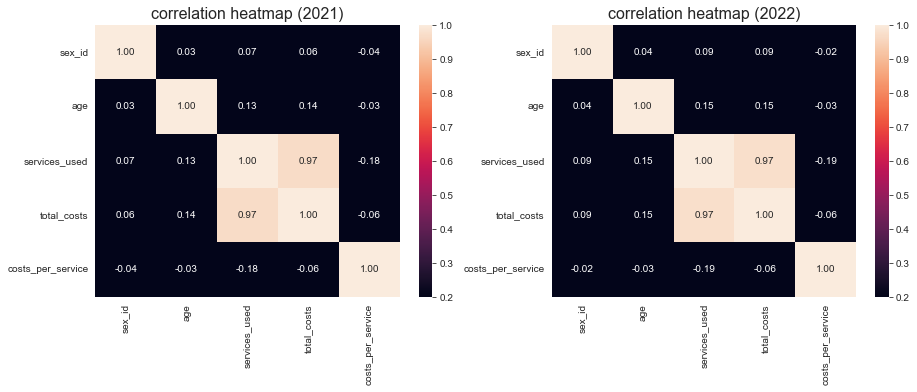

In [32]:
# визуализируем коэффициенты корреляции значений таблиц

fig, (ax1, ax2) = plt.subplots(1, 2)

sns.heatmap(patients_2021.corr(), 
            fmt='.2f', 
            annot=True, 
            vmin=0.2,
            ax=ax1)

sns.heatmap(patients_2022.corr(), 
            fmt='.2f', 
            annot=True, 
            vmin=0.2,
            ax=ax2)

ax1.set_title('correlation heatmap (2021)')
ax2.set_title('correlation heatmap (2022)')

plt.show()

* Высокая положительная корреляция между количеством полученных услуг и общей суммой затрат сохраняется в обоих периодах.

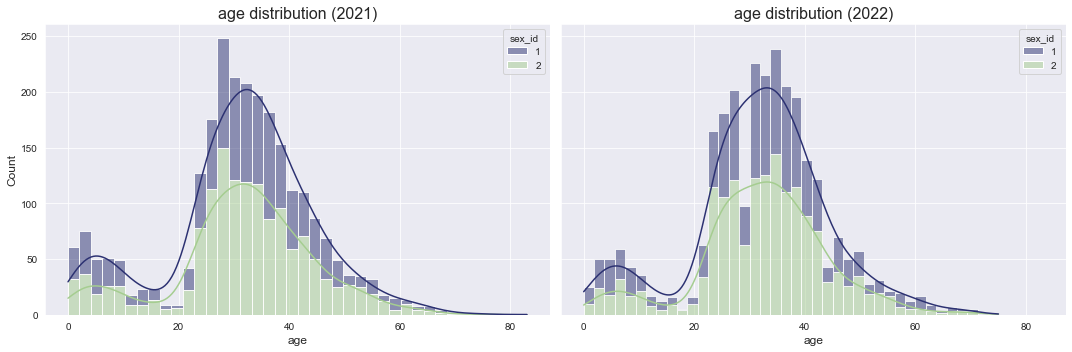

In [33]:
# дополним функцию из предыдущего этапа

def yearly_pop_overview(par, bins=100, limit=100):

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
    
    lim = np.percentile(eda_patients[par], limit)

    pop_overview(par, bins, patients_2021[patients_2021[par] <= lim], ax1, 'crest_r')
    pop_overview(par, bins, patients_2022[patients_2022[par] <= lim], ax2, 'crest_r')
    
    ax1.set_title(par + ' distribution (2021)')
    ax2.set_title(par + ' distribution (2022)')
    
    plt.tight_layout()    

# визуализируем распределение по возрасту

yearly_pop_overview('age', 40)

* Форма распределения в целом схожа - в обоих случаях сохраняется просадка в районе 20 лет, большая часть пациентов представлена диапазоном от 20 до 40 лет. Основное отличие - там, где происходит резкий скачок количества пациентов в общем распределении   (около 30 лет), тенденция явно прослеживается только в 2021-ом году, а вот в 2022-ом всё наоборот - в этом месте количество пациентов резко проседает. Тогда как средний возраст клиента одинаков для обоих периодов, в 2022-ом чаще всего встречаются пациенты ближе к возрасту в 40 лет. При этом в 2022-ом меньше клиентов 60+, клиентов 80+ не отмечается вовсе.

Далее изучим количество полученных услуг и сумму затрат, также ограничив значением 90%:

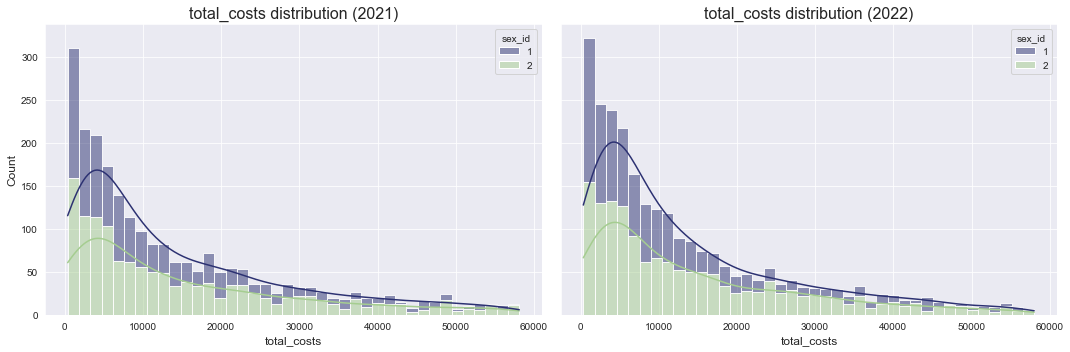

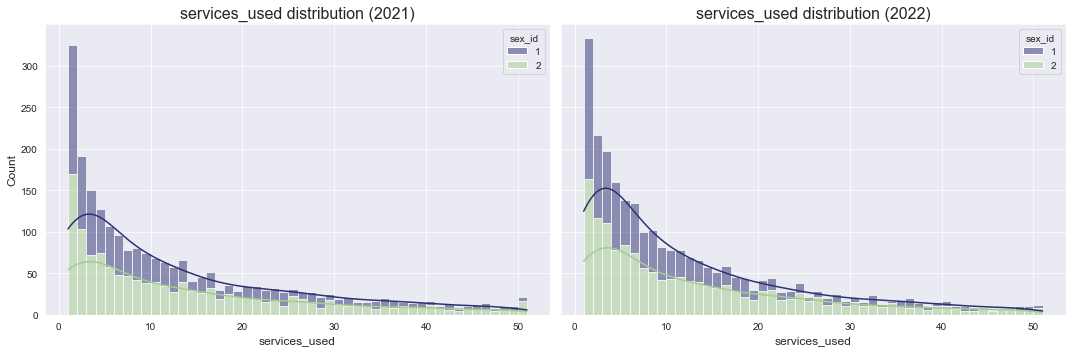

In [34]:
# визуализируем распределение по общей стоимости услуг

yearly_pop_overview('total_costs', 40, 90)
plt.show()

# визуализируем распределение общего количества полученных услуг

yearly_pop_overview('services_used', 50, 90)
plt.show()

* Распределения общей суммы затрат и количества использованных услуг также схожи между собой и в разрезе периодов. Отличия между 2021-ым и 2022-ым годами скорее всего обусловлено б*о*льшим общим количеством пациентов в последнем. 

Последний параметр - средняя стоимость одной услуги для каждого клиента:

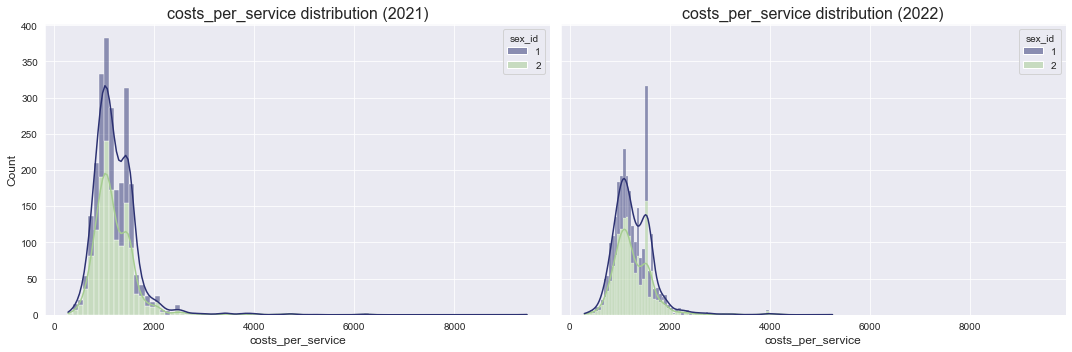

In [35]:
# визуализируем распределение

yearly_pop_overview('costs_per_service', 90)

Внешне распределение похоже, но из-за аномально высоких значений в 2021-ом году сложно сопоставить графики. Попробуем ограничить данные, убрав наиболее явные выбросы:

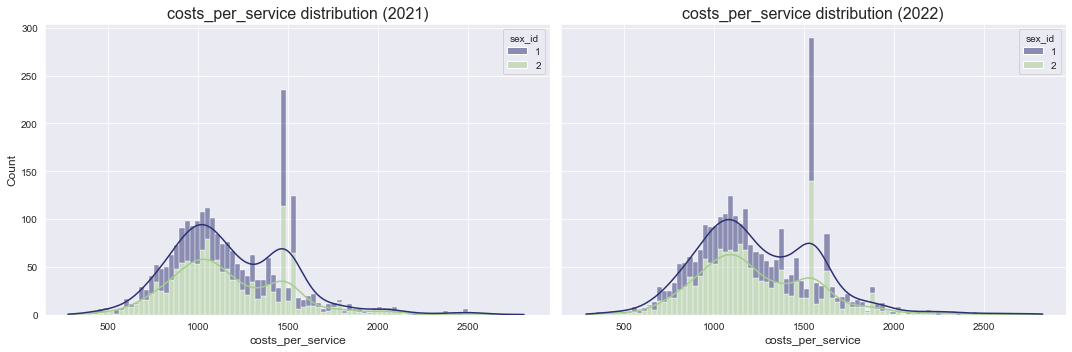

In [36]:
# визуализируем 99% данных

yearly_pop_overview('costs_per_service', 90, 99)

* Распределения также имеют два пика - на уровне **1,000** и **1,500** рублей, причём второй очень ярко выбивается из распределения, особенно в 2022-ом году - практически вся разница в количестве клиентов приходится именно на это значение. Абсолютное большинство пациентов имеют средний расход на одну услугу в диапазоне от **500 до 1,500 рублей**

<a id='2.4'></a>
### Вывод

Так как все основные гипотезы исследования завязаны на динамике стоимости лечения пацентов клинике, основным источником для исследования стал датасет, сгруппированный по уникальным идентификатором клиентов, а затем разделённый на 2021 и 2022 год. Основными группами параметров для рассмотрения стали **общая сумма затрат**, **количество оказанных услуг и средняя стоимость одной услуги**, **количество уникальных пациентов, их средний возраст и соотношение по полу**.  В ходе исследования сначала было изучено распределение основных значений в динамике дат предоставления услуг, после чего данные были исследованы в разрезе клиентов, и в итоге - сопоставлены по годам.

Таким образом, исследовательский анализ был разделён на следующие этапы:

1. [**Динамика использования услуг клиники**](#2.1)

Данные были сгруппированы по месяцу предоставления услуги, после чего были исследованы распределения основных параметров:

* В среднем на каждый месяц работы клиники приходится **536** уникальных пациентов. Среднее число предоставляемых услуг - **4,366**, а общая сумма затрат составляет **4,977,417 рублей**. Средняя стоимость услуги составляет **1,134 рубля**, одному клиенту в среднем предоставляются услуги на **9,205 рублей**.


* Коэффициенты корреляции между сочетаниями параметров количества уникальных посетителей, количества предоставленных услуг и общей сумме затрат достигают максимальных значений. Это может указывать на незначительное влияние остальных параметров на среднюю сумму затрат, в частности поло-возрастной структуры пациентов или увеличения стоимости отдельных услуг.


* Количество уникальных пациентов в месяц стабильно растёт на протяжении всего рассматриваемого периода, после чего происходит резкий спад в августе 2022-го года. Возможно резкое падение обусловлено недостатком данных за этот период. Наибольшое число пациентов приходится на апрель-май 2022-го года - около **800** уникальных пациентов.


* Распределение пациентов по полу имеет неравномерную структуру на протяжении всего периода. Самая очевидная закономерность - самый большой разрыв приходится на май как 2021-го, так и 2022-го года. Наибольшее равенство полов наблюдается в декабре 2021-го.


* Описать динамику среднего возраста пациента можно описать следующим образом: рассматриваемый период начинается со значения, близкому к общему среднему, в феврале 2021-го происходи спад, который сменяеться стабильным ростом вплоть до июля. Затем на протяжении следующих двух месяцев происходит резкий спад, достигая минимального значения в сентября (**возраст < 31 года**), после чего график снова растёт вплоть до конца 2021-го года. В начале 2022 происходит небольшой спад, затем также начинается стабильный рост, небольшой провал в июле, а в конце - резкий скачок, достигающий пика всего рассматриваемого периода (**возраст ~ 35.5 лет**).


* На протяжении всего рассматриваемого периода прослеживается тенденция роста общей суммы затрат на обслуживание клиентов, за исключением августа 2022 - возможно резкое падение также обусловлено недостатком данных, как и в случае количества уникальных пациентов. Пиком значения за 2021 год является октябрь, сумма составляет **~6,000,000 рублей**, а пиком 2022 года и всего рассматриваемого периода - апрель, сумма составляет **~8,000,000 рублей**. Несмотря на то, что пик уникальный посетителей приходится на май, общая сумма выше именно в апреле, что может говорить о большей популярности дорогостоящих процедур в этом месяце.


* Динамика количества оказанных услуг полностью идентична графику распределения общей выручки, что обусловлено их полностью положительной корреляции, выявленной ранее. Пиком значения за 2021 год  также является октябрь (**~5,000 услуг**), а пиком 2022 года и всего рассматриваемого периода - апрель (**~7,000 услуг**).


* График средней стоимости одной услуги показывает рост на протяжении всего рассматриваемого периода. Распределение значений в 2022-ом году становиться более равномерным, что может указывать на плановое повышение стоимости предоставляемых услуг. Пик стоимости одной услуги достигает в июле 2022-го года, под конец рассматриваемого периода (в средней более **1,250 рублей за  услугу**)


* Форма графика суммы затрат на одного клиента по своей форме не совпадает не с одним из других рассматриваемых параметров - пики значений приходятся на июнь и октябрь 2021-го года, что никак не коррелирует с пиками количества уникальных посетителей, количестве предоставляемых услуг и общей выручке. Это может указывать на популярность наиболее дорогостоящих услуг клиники в эти периоды.

2. [**Анализ пациентов**](#2.2)


Данные были сгруппированы по уникальному идентификатору клиента и изучены в разрезе основных параметров.

* В среднем каждый пациент за рассматриваемый период получает **19** медицинских услуг общей стомостью **22,181 рубль**, средняя стоимость услуги - **1, 245 рублей**. Средний возраст пациента - **32 года**, соотношение полов в разрезе пациентов сохраняется на уровне **60/40**.


* Количество предоставленных услуг и общая сумма затрат характерны высоким стандартным отклонением, многократно превыщающим медиану - это указывает на большое количество аномально высоких значений внутри этих показателей. 


* В срезе по уникальным клиентам сохраняется максимальная положительная корреляция между количеством полученных услуг и общей суммой затрат.


* Форма распределения возрастов клиентов в разрезе пола в целом не отличается - в обоих случаях наблюдается просадка в районе 20 лет (возможно обусловлено тем, что в подростковом возрасте клиенты не часто прибегают к медицинской помощи), большая часть пациентов представлена диапазоном от 20 до 40 лет. В возрасте около 30 лет происходит резкий скачок количества пациентов, достигающий пика для обоих полов.


* Распределение общей суммы затрат и количества использованных услуг ожидаемо схоже - это подкрепляется их высоким коэффициентом корреляции. Для абсолютного большинства клиентов характрно не более **20,000 рублей** общих затрат и не более **20 полученных услуг**, но при этом пик, с большим отрывом, приходится на **1,000 рублей** и **1 услугу**.  


* Абсолютное большинство пациентов имеют средний расход на одну услугу в диапазоне от **500 до 2,000 рублей**, количество остальных пациентов незначительно. Распределение имеет два пика - на уровне **1,000** и **1,500** рублей, между ними происходит незначительный провал. Форма распределения также не менятся в зависимости от пола пациента.

3. [**Сравнение данных за 2021 и 2022 годы**](#2.3)

Все шаги предыдущего этапа были повторены в разрезе двух лет и сопоставлены между собой.

* В целом показатели не отличаются от значений за весь рассматриваемый период, за исключенем количества полученных услуг (**18 услуг за 2021 против 19 за весь период**) и общей суммы затрат (**26,106 рублей** за 2021 и **22,181 рубль** в среднем за весь период, при том что средняя стоимость услуги остаётся на том же уровне). Это может указывать на большую попопулярность дорогостоящего лечения в 2021-ом году.


* Показатели за 2022-ой год также схожи с значениями за весь рассматриваемый период, и значительно отличаются только количеством полученных услуг (**15 услуг за 2022 против 19 за весь период**) и общей суммой затрат (**17,768 рублей** за 2022 и **22,181 рубль** в среднем за весь период, при том что средняя стоимость услуги остаётся на том же уровне). Это может характеризовать 2022-ой год как менее популярный для дорогостоящего лечения.


* Количество пациентов за оба периода сопоставимо - **2,515 уникальных пациентов** пользовались услугами клиники в 2021-ом году и **2,757 уникальных пациентов** посетило клинику в 2022-ом. Это может говорить как о хорошем удержании старых пациентов, так и о значительном привлечении новых - в 2022-ом году было больше уникальных пациентов, несмотря на ограничение данных концом августа.


* Высокая положительная корреляция между количеством полученных услуг и общей суммой затрат сохраняется в обоих периодах.


* Форма распределения возрастов пациентов в целом схожа - в обоих случаях сохраняется просадка в районе 20 лет, большая часть пациентов представлена диапазоном от 20 до 40 лет. Основное отличие - там, где происходит резкий скачок количества пациентов в общем распределении   (около 30 лет), тенденция явно прослеживается только в 2021-ом году, а вот в 2022-ом всё наоборот - в этом месте количество пациентов резко проседает. Тогда как средний возраст клиента одинаков для обоих периодов, в 2022-ом чаще всего встречаются пациенты ближе к возрасту в 40 лет. При этом в 2022-ом меньше клиентов 60+, клиентов 80+ не отмечается вовсе.


* Распределения общей суммы затрат и количества использованных услуг также схожи между собой и в разрезе периодов. Отличия между 2021-ым и 2022-ым годами скорее всего обусловлено б*о*льшим общим количеством пациентов в последнем. 


* Распределения средней стоимости услуги также имеют два пика - на уровне **1,000** и **1,500** рублей, причём второй очень ярко выбивается из распределения, особенно в 2022-ом году - практически вся разница в количестве клиентов приходится именно на это значение. Абсолютное большинство пациентов имеют средний расход на одну услугу в диапазоне от **500 до 1,500 рублей**

<a id='3'></a>
## Проверка гипотез
На данном этапе исследования будут проверены следующие гипотезы:

* [**Средняя стоимость обслуживания изменилась из-за изменения интенсивности лечения пациентов**](#3.1)
* [**Средняя стоимость обслуживания пациентов изменилась из-за изменения цен на услуги**](#3.2)
* [**Средняя стоимость обслуживания пациентов изменилась из-за изменения поло-возрастной структуры обслуживаемых пациентов**](#3.3)

Целевым параметром для проверки всех гипотез станет **средняя стоимость обслуживания за один визит клиента**, а основным источником данных - датафрейм с основными параметрами, сгруппированный по идентификатору клиента. Перед началом проверки гипотез сформируем основную таблицу:

In [37]:
# группируем данные

test = (
    data
    .pivot_table(index=['insured', 'service_date'], 
                 aggfunc={'service_amount':'sum', 
                          'service_number':'sum',
                          'age_for_service_date':'mean',
                          'sex_id':'median',
                          'service_price':'mean'})
    .reset_index()
    .groupby('insured')
    .agg('mean')
    .rename(columns={'service_amount':'mean_visit_costs', 
                     'service_number':'services_per_visit',
                     'age_for_service_date':'age',
                     'service_price':'mean_service_price'})
)

# выводим результат

test.describe()

,age,mean_visit_costs,services_per_visit,mean_service_price,sex_id
count,"4,488.00","4,488.00","4,488.00","4,488.00","4,488.00"
mean,31.76,"3,246.05",2.88,"1,363.17",1.57
std,12.79,"1,738.32",1.85,428.39,0.50
min,0.00,290.00,1.00,277.08,1.00
25%,26.00,"2,073.34",1.67,"1,144.00",1.00
50%,33.00,"2,916.37",2.50,"1,317.52",2.00
75%,39.00,"3,910.10",3.53,"1,515.00",2.00
max,83.00,"18,018.00",25.00,"9,450.00",2.00


Взглянем на общую взамосвязь между данными:

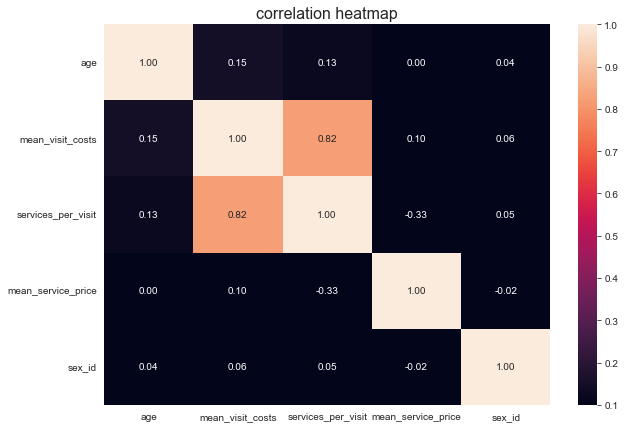

In [38]:
plt.figure(figsize=(10, 7))

sns.heatmap(test.corr(), 
            fmt='.2f', 
            annot=True, 
            vmin=0.1)
plt.title('correlation heatmap')
plt.show()

* В данных наблюдатся высокая корреляция количества оказанных услуг и средней стоимости визита.

Проверим пригодность остальных параметров (не имеющих корреляции) на пригодность к факторному анализу с помощью критерия Бартлетта и теста Кайзера-Мейера-Олкина (КМО):

In [39]:
# расчитываем критерий Бартлетта

chi_square_value, p_value = (
    calculate_bartlett_sphericity(test)
)
chi_square_value, p_value

(8517.360837958666, 0.0)

В результати получили p_value = 0, что подтверждает статистическую значимость теста

In [40]:
# запускаем тест Кайзера-Мейера-Олкина (КМО)

kmo_all, kmo_model = calculate_kmo(test.drop(columns='services_per_visit'))
kmo_model

0.5042521643919423

КМО выше значения 0.5, что указывает на адекватность использования факторного анализа

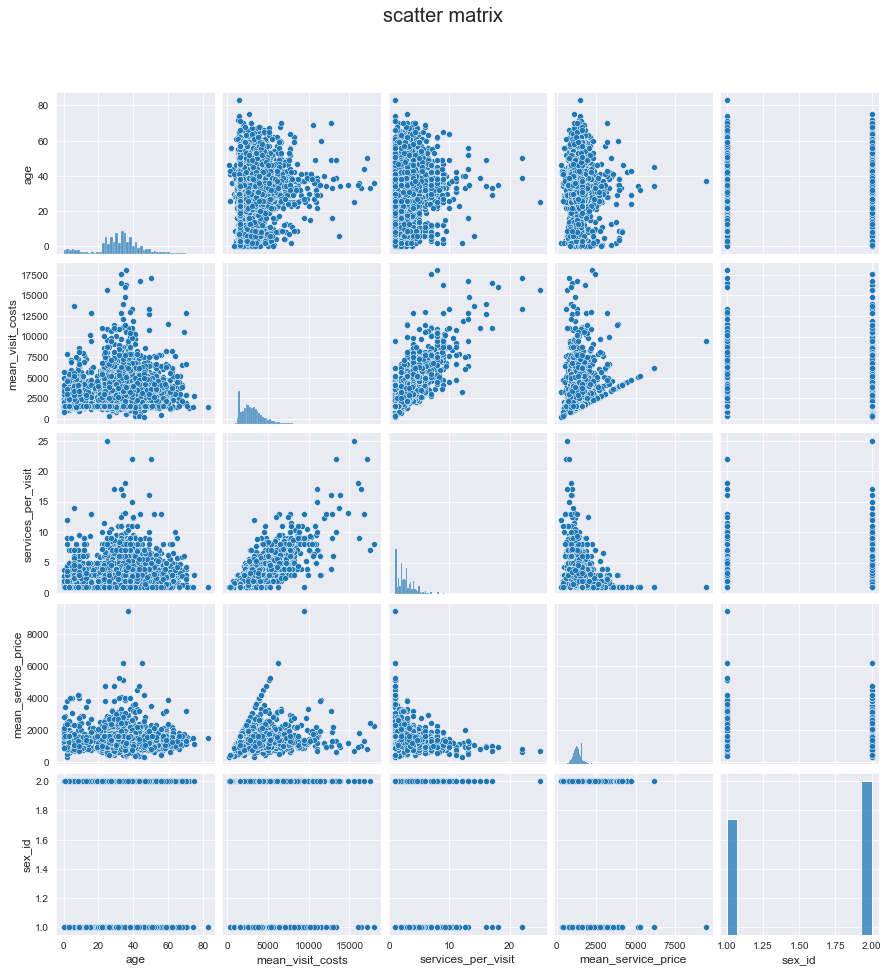

In [41]:
# визуализируем матрицу рассеяния

g = sns.pairplot(test)

g.fig.suptitle("scatter matrix", y=1.08, fontsize=20)
plt.show()

* На матрице рассеяния можно заметить несколько закономерностей относительно средней стоимости визита - часть наблюдений имеет линейную зависимость с средней стоимостью услуг (часть клиентов получают лишь одну услугу за визит), сочетания с показателем возраста напоминает нормальное распределение с пиком посредине (около 40 лет), у пациентов с `sex_id 1` наблюдаются аномально высокие значения.

<a id='3.1'></a>
### Влияние интенсивности лечения пациентов

Так как ранее была уже выявлена высокий уровень корреляции количества услуг и средней цены визита, уже на данном этапе можно утверждать, что интенсивность лечения является основным драйвером роста целевого показателя. Расчитаем статистическую значимость изменения количества услуг с 2021 по 2022 для полной картины:

In [44]:
# добавим столбец с годом оказания услуги

data['service_year'] = data['service_date'].dt.year


# фильтруем данные

patient_id_2021 = (
    data
    .query('service_year == 2021')['insured']
    .unique()
    .tolist()
)

patient_id_2022 = (
    data
    .query('service_year == 2022')['insured']
    .unique()
    .tolist()
)

test_2021 = (
    test
    .reset_index()
    .query('insured in @patient_id_2021')
)

test_2022 = (
    test
    .reset_index()
    .query('insured in @patient_id_2022')
)

Посмотрим на средние значения стоимости визита за каждый год:

In [45]:
# выводим среднюю стоимость визита за каждый год

visit_2021 = round(test_2021['mean_visit_costs'].mean())
visit_2022 = round(test_2022['mean_visit_costs'].mean())

print(f'''Средняя стоимость визита одного клиента\n
2021 год - {visit_2021} рублей
2022 год - {visit_2022} рублей\n
Разница составляет {round((visit_2022/visit_2021-1)*100, 2)}%
''')

Средняя стоимость визита одного клиента

2021 год - 3115 рублей
2022 год - 3348 рублей

Разница составляет 7.48%



- Средняя стоимость визита одного клиента в 2022-ом году увеличилась на 7.5%

Проверим гипотезу о разнице средних значений количества оказанных услуг. Если она подтвердится, то благодаря высокому коэффициенту корреляции можно будет утверждать, что средняя стоимость визита увеличилась благодаря увеличению интенсивности лечения клиентов. Так как в ходе исследования при работе с этим показателем неоднократно были замечены выбросы, используем непараметрический тест Манна-Уитни.

**Нулевая гипотеза** - Среднее количество оказанных услуг в 2021 и 2022 не имеют статистически значимых отличий

**Альтернативная гипотеза** - Среднее количество оказанных услуг в 2022 году статистически значимо больше, чем в 2021

In [46]:
# формируем выборки, выставляем стандартное пороговое значение стат.значимости

sample_a = test_2021['services_per_visit']
sample_b = test_2022['services_per_visit']
alpha = 0.05

# запускаем тест

results = st.mannwhitneyu(sample_a, sample_b)
difference = "{0:.2f}".format((sample_b.mean() / sample_a.mean() - 1)*100)

# так как альтернативная гипотеза одностороннаяя - делим p-value на 2

print('p-value: ', "{0:.3f}".format(results.pvalue/2))

if results.pvalue/2 < alpha:
    
    print('Отвергаем нулевую гипотезу: разница статистически значима')
    
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
    
print()    
print(f'Относительное различие средних значений выборок: {difference}%')    

p-value:  0.005
Отвергаем нулевую гипотезу: разница статистически значима

Относительное различие средних значений выборок: 2.44%


* Проверка гипотезы о разнице средних значений количества оказанных услуг показала, что среднее количество оказанных услуг в 2022 году статистически значимо больше, чем в 2021. С учётом высокого коэффициента корреляции (> 0.8) с значением средней стоимости визита пациента, можно смело предположить, что интенсивность лечения пациентов является ключевым драйвером роста стоимости обслуживания.

<a id='3.2'></a>
### Влияние изменения цен на услуги

Данные будут дополнительно сгруппированы для оценки статистической значимости изменения стоимости услуг между 2021-ым и 2022-ым годом, и в случае выявления статистически значимой разницы значений влияние этого параметра на стоимость визита будет рассмотрено в дальнейшем. Из-за специфики гипотезы оценка влияния будет проводится только для услуг, которые были оказаны в обоих периодах.

In [47]:
# группируем данные по медицинским услугам

services = (
    data
    .pivot_table(index='service_name', 
                 values='service_price', 
                 columns='service_year', 
                 aggfunc='mean')
    .dropna()
    .reset_index()
    .rename(columns={'service_name':'service',
                     2021:'2021_price',
                     2022:'2022_price'})
)

services['%variance'] = (
    services['2021_price']/services['2022_price']
)

# выводим результат

services.info()
display(services.describe())
services.sample(10, random_state=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   service     543 non-null    object 
 1   2021_price  543 non-null    float64
 2   2022_price  543 non-null    float64
 3   %variance   543 non-null    float64
dtypes: float64(3), object(1)
memory usage: 17.1+ KB


service_year,2021_price,2022_price,%variance
count,543.00,543.00,543.00
mean,"1,320.34","1,374.58",0.96
std,"1,213.00","1,264.40",0.03
min,147.38,150.00,0.86
25%,564.19,593.16,0.95
50%,"1,021.00","1,070.00",0.96
75%,"1,540.00","1,554.52",0.97
max,"7,857.50","8,312.50",1.35


service_year,service,2021_price,2022_price,%variance
103,Взятие соскоба с ногтевых пластинок и гладкой ...,165.88,172.22,0.96
179,Исследование пунктатов щитовидной железы,815.83,888.64,0.92
474,Удаление инородного тела мягких тканей,"5,145.00","5,400.00",0.95
345,"Прием офтальмолога, первичный","1,540.00","1,555.91",0.99
132,"Глюкоза крови через 60 мин, после нагрузки",181.20,200.00,0.91
236,Магнитотерапия (1 сеанс),"1,056.63","1,096.36",0.96
118,Гепатит А anti-HAV IgM,630.00,660.00,0.95
75,Антитела к возбудителю паракоклюша,630.00,660.00,0.95
480,Удаление радиохирургическим ножом пигментного ...,"4,074.00","4,280.00",0.95
395,Пыльца ежи,"1,155.00","1,210.00",0.95


* В данных представлено **543 уникальные услуги**, которые были оказаны и в 2021, и в 2022 году.


* В среднем цены на услуги выросли на **~1%**.

Проверим гипотезу о разнице средней стоимости услуги. Описательная статистика таблиц указывает на нормальное распределение значений, что позволяет использовать для проверки Т-критерий Стьюдента (t-test).

**Нулевая гипотеза** - Средняя стоимость оказанных услуг в 2021 и 2022 не имеет статистически значимых отличий

**Альтернативная гипотеза** - Средняя стоимость оказанных услуг в 2022 значительно больше стоимости в 2021

In [48]:
# формируем выборки, выставляем стандартное пороговое значение стат.значимости

sample_a = services['2021_price']
sample_b = services['2022_price']
alpha = 0.05

# запускаем тест

results = st.ttest_ind(sample_a, sample_b)
difference = "{0:.2f}".format((sample_b.mean() / sample_a.mean() - 1)*100)

print('p-value: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    
    print('Отвергаем нулевую гипотезу: разница статистически значима')
    
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
    
print()    
print(f'Относительное различие средних значений выборок: {difference}%')    

p-value:  0.471
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Относительное различие средних значений выборок: 4.11%


* Проверка гипотезы о разнице средней стоимости услуг не показала статистически значимых отличий, несмотря не разницу значений выборок. Это может указывать на отсутствии влияния увеличения стоимости услуг на среднюю стоимость визита. С учётом полного отсутствия корреляции этих двух параметров можно сделать вывод о том, что стоимость услуг не является драйвером роста стоимости визита.

<a id='3.3'></a>
### Влияние изменения поло-возрастной структуры обслуживаемых пациентов

Пол и возраст пациентов сами по себе не имеют какой-либо корреляции со средней стоимостью визита. Попробуем классифицировать пациентов с помощью алгоритмов кластеризации, после чего проверим статистическую значимость различий средних значений между разными группами.

In [ ]:
# используем алгоритм иерархической кластеризации для определения числа групп поло-возрастной структуры

scaler = StandardScaler()

data_sc = scaler.fit_transform(test[['age', 'sex_id']])
linked = linkage(data_sc, method = 'ward')

# визуализируем результат в виде дендрограммы

dendrogram(linked, orientation='top')

plt.title('Иерархическая кластеризация признаков')
plt.show()

Алгоритм разделил данные на три кластера - используем полученную информацию для кластеризации с помощью алгоритма "K-Means":

In [ ]:
# задаём 3 кластера для модели и обучаем на стандартизированных данных

km = KMeans(n_clusters=3, random_state=0)
clusters = km.fit_predict(data_sc)

# сохраняем метки кластера в поле нашего датасета

test['cluster'] = clusters

Теперь мы можем группировать данные по выделенным кластерам. Сделаем сводную таблицу за оба рассматриваемых периода:

In [ ]:
# группируем данные

pop_test_2021 = (
    test
    .query('insured in @patient_id_2021')
    .groupby('cluster')
    .agg({'age':'mean',
          'sex_id':'mean',
          'mean_visit_costs':'mean',
          'services_per_visit':'count'})
    .rename(columns={'services_per_visit':'patients'})
    .drop(columns=['mean_service_price'])
    .reindex(columns=['patients', 
                      'age', 
                      'sex_id', 
                      'mean_visit_costs'])
    )

pop_test_2022 = (
    test
    .query('insured in @patient_id_2022')
    .groupby('cluster')
    .agg({'age':'mean',
          'sex_id':'mean',
          'mean_visit_costs':'mean',
          'services_per_visit':'count'})
    .rename(columns={'services_per_visit':'patients'})
    .drop(columns=['mean_service_price'])
    .reindex(columns=['patients', 
                      'age', 
                      'sex_id', 
                      'mean_visit_costs'])
    )

# выводим результат

display(pop_test_2021, pop_test_2022)

* Алгоритм кластеризации разделил всех пациентов на три группы - дети, мужчины и женщины. Соотношение всех параметров соопоставимо между рассматриваемыми периодами.

Проверим гипотезу о разнице в соотношении поло-возрастной группы пациентов между 2021 и 2022. Так как данные для расчёта статистической значимости являются долями, оптимальным инструментом станет Z-критерий Фишера.

**Нулевая гипотеза** - Доля пациентов из поло-возрастной группы в 2021 и 2022 не имеет статистически значимых отличий

**Альтернативная гипотеза** - Доля пациентов из поло-возрастной группы в 2021 и 2022 отличается

In [ ]:
# проименуем кластеры

test['cluster'].replace({0:'child', 
                         1:'sex_id_1', 
                         2:'sex_id_2'}, 
                         inplace=True)
# группируем данные

years = (
    pd.Series([2021, 2021, 2021, 2022, 2022, 2022])
    .to_frame()
)

final_test = (
    pd.concat([pop_test_2021, pop_test_2022])
    .reset_index()
    .merge(years, left_index=True, right_index=True, how='outer')
    .drop(columns=['age', 'sex_id', 'mean_visit_costs'])
    .rename(columns={0:'year'})
    .reindex(columns=['cluster', 'year', 'patients'])
)

In [ ]:
# напишем функцию для проверки гипотезы

def stat_check(patients_2021, 
               patients_2022, 
               total_patients_2021, 
               total_patients_2022, 
               alpha=.05):
    
    p1 = patients_2021/total_patients_2021
    p2 = patients_2022/total_patients_2022
    p_combined = (patients_2021 + patients_2022) / (total_patients_2021 + total_patients_2021)

    difference = p1 - p2
    z_value = (
        difference / mth.sqrt(
            p_combined * (1 - p_combined) * (
                1/total_patients_2021 + 1/total_patients_2022))
    )

    distr = st.norm(0, 1) 
    alpha = alpha

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', "{0:.3f}".format(p_value))

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу, есть основания полагать, что данные отличаются")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы ")  

In [ ]:
# создадим необходимые для проверки переменные

# количество пациентов каждой группы

total_2021 = final_test.query('year==2021')['patients'].sum()
total_2022 = final_test.query('year==2022')['patients'].sum()

# список групп

test_list = (
    final_test['cluster']
    .unique()
    .tolist()
)

In [ ]:
# функция для получения значения группы

def get_val(group):
    val = int(
        final_test.query(
            'cluster == @cluster and year == @group')
        ['patients'])
    return val

# запускаем цикл проверки всех групп


for cluster in test_list:
    
    a = get_val(2021)
    b = get_val(2022)
    
    print(f'Проверка пациентов 2021 и 2022 в группе "{cluster}"')
    print()
    stat_check(a, b, total_2021, total_2022)
    run_count += 1
    print()

* Проверка гипотезы о разнице в соотношении поло-возрастной группы пациентов между 2021 и 2022 показала статистически значимые отличия только в сегменте пациентов `sex_id_2`. Это позволяет предположить влияние количества пацентов этого сегмента на изменение средней стоимости визита, но к сожалению это не подкрепляется значением коэффициента корреляции.

### Вывод

На данном этапе исследования были проверены следующие гипотезы:

* [**Средняя стоимость обслуживания изменилась из-за изменения интенсивности лечения пациентов**](#3.1)
* [**Средняя стоимость обслуживания пациентов изменилась из-за изменения цен на услуги**](#3.2)
* [**Средняя стоимость обслуживания пациентов изменилась из-за изменения поло-возрастной структуры обслуживаемых пациентов**](#3.3)

Целевым параметром для проверки всех гипотез стала **средняя стоимость обслуживания за один визит клиента**, а основным источником данных - датафрейм с основными параметрами, сгруппированный по идентификатору клиента. 

В ходе исследования на этом этапе были сделаны следующие выводы:

* В данных наблюдатся высокая корреляция количества оказанных услуг и средней стоимости визита (**коэффициент > 0.8**).


* На матрице рассеяния можно заметить несколько закономерностей относительно средней стоимости визита - часть наблюдений имеет линейную зависимость с средней стоимостью услуг (часть клиентов получают лишь одну услугу за визит), сочетания с показателем возраста напоминает нормальное распределение с пиком посредине (около 40 лет), у пациентов с `sex_id 1` наблюдаются аномально высокие значения.


* Средняя стоимость визита одного клиента в 2022-ом году увеличилась на 7.5%


* Проверка гипотезы о разнице средних значений количества оказанных услуг показала, что среднее количество оказанных услуг в 2022 году статистически значимо больше, чем в 2021. С учётом высокого коэффициента корреляции (> 0.8) с значением средней стоимости визита пациента, можно смело предположить, что интенсивность лечения пациентов является ключевым драйвером роста стоимости обслуживания.


* В данных представлено **543 уникальные услуги**, которые были оказаны и в 2021, и в 2022 году.


* В среднем цены на услуги выросли на **~1%**.


* Проверка гипотезы о разнице средней стоимости услуг не показала статистически значимых отличий, несмотря не разницу значений выборок. Это может указывать на отсутствии влияния увеличения стоимости услуг на среднюю стоимость визита. С учётом полного отсутствия корреляции этих двух параметров можно сделать вывод о том, что стоимость услуг не является драйвером роста стоимости визита.


* Алгоритм кластеризации разделил всех пациентов на три группы - дети, мужчины и женщины. Соотношение всех параметров соопоставимо между рассматриваемыми периодами.


* Проверка гипотезы о разнице в соотношении поло-возрастной группы пациентов между 2021 и 2022 показала статистически значимые отличия только в сегменте пациентов `sex_id_2`. Это позволяет предположить влияние количества пацентов этого сегмента на изменение средней стоимости визита, но к сожалению это не подкрепляется значением коэффициента корреляции.

<a id='4'></a>
## Общий вывод

____
**Ключевой вывод**

* Проверка гипотезы о разнице средних значений количества оказанных услуг показала, что среднее количество оказанных услуг в 2022 году статистически значимо больше, чем в 2021. С учётом высокого коэффициента корреляции (> 0.8) с значением средней стоимости визита пациента, можно смело предположить, что интенсивность лечения пациентов является ключевым драйвером роста стоимости обслуживания.
____

Целью исследования являлось проведение анализа изменения цены лечения в 2022 году относительно 2021 года в медицинской клинике и определение ключевых драйверов изменения цены лечения. 


Данные были представлены в файле `data_test_task_2022.xlsx` - это срез истории оказанных медицинских услуг, содержащий информацию дате, наименовании и стоимости услуг, а также основную информацию о клиенте. Данные были предобработаны - проведена проверка на наличие пропущенных значений и дубликатов, корректность типа хранимых данных, были добавлены дополнительные столбцы. Затем был проведён исследовательский анализ, целью которого станет поиск характерных признаков, оказывающих влияние на стоимость услуг клиники, а также возможные признаки для сегментации. На основе выводов были сформированы показатели, которые были использованы для проверки следующих гипотез:

* Средняя стоимость обслуживания изменилась из-за изменения интенсивности лечения пациентов
* Средняя стоимость обслуживания пациентов изменилась из-за изменения цен на услуги
* Средняя стоимость обслуживания пациентов изменилась из-за изменения поло-возрастной структуры обслуживаемых пациентов

Таким образом, исследование было разбито на следующие этапы:

1. [**Обзор и предобработка данных**](#1)

Обработанные данные представлены в виде таблицы, содержащей **85,369** строк и **9** столбцов. Был провёден обзор таблицы и описание данных из документации заказчика. В ходе предобработке изучены с точки зрения общих распределений значений и наличия дубликатов, пропущенные значения были обработаны. Данные были приведены к корректным типам хранения, что позволило уменьшить объём ресурсов используемой памяти на **69%**.

В ходе предобработки были сделаны следующие выводы:

* Таблица содержит данные об оказанных услугах с **03-01-2021** по **31-08-2022**. Так как данные за 2022 год ограничены августом, выборки данных по датам при сравнении могут быть неравномерными, а потому не являтся репрезентативными.


* В данных содержатся сведения об **875** уникальных медицинских услуг, самыми популярными из которых являются `Приём первичный`, `Приём повторный` и `Взятие крови из периферической вены`


* Минимальная стоимость оказанных услуг составляет **147 рублей**, максимальная - **26,999 рублей**. В среднем стоимость оказанных медицинских услуг в клинике составляет **1,166 рублей**.


* В данных представлены **4,488** уникальных клиентов. Чаще всего к услугам клиники прибегает клиент с идентификатором `441893`


* Примерное соотношение пациентов по полу составляет **40/60**.


* Диапазон возраста клиентов - от **0** до **83**. Средний возраст пациента клиники составляет **34 года**. Такой широкий разброс даёт возможность для сегментации клиентов по возрасту.

2. [**Исследовательский анализ данных**](#2)

Так как все основные гипотезы исследования завязаны на динамике стоимости лечения пацентов клинике, основным источником для исследования стал датасет, сгруппированный по уникальным идентификатором клиентов, а затем разделённый на 2021 и 2022 год. Основными группами параметров для рассмотрения стали **общая сумма затрат**, **количество оказанных услуг и средняя стоимость одной услуги**, **количество уникальных пациентов, их средний возраст и соотношение по полу**.  В ходе исследования сначала было изучено распределение основных значений в динамике дат предоставления услуг, после чего данные были исследованы в разрезе клиентов, и в итоге - сопоставлены по годам.

Таким образом, исследовательский анализ был разделён на следующие этапы:

[**Динамика использования услуг клиники**](#2.1)

Данные были сгруппированы по месяцу предоставления услуги, после чего были исследованы распределения основных параметров:

* В среднем на каждый месяц работы клиники приходится **536** уникальных пациентов. Среднее число предоставляемых услуг - **4,366**, а общая сумма затрат составляет **4,977,417 рублей**. Средняя стоимость услуги составляет **1,134 рубля**, одному клиенту в среднем предоставляются услуги на **9,205 рублей**.


* Коэффициенты корреляции между сочетаниями параметров количества уникальных посетителей, количества предоставленных услуг и общей сумме затрат достигают максимальных значений. Это может указывать на незначительное влияние остальных параметров на среднюю сумму затрат, в частности поло-возрастной структуры пациентов или увеличения стоимости отдельных услуг.


* Количество уникальных пациентов в месяц стабильно растёт на протяжении всего рассматриваемого периода, после чего происходит резкий спад в августе 2022-го года. Возможно резкое падение обусловлено недостатком данных за этот период. Наибольшое число пациентов приходится на апрель-май 2022-го года - около **800** уникальных пациентов.


* Распределение пациентов по полу имеет неравномерную структуру на протяжении всего периода. Самая очевидная закономерность - самый большой разрыв приходится на май как 2021-го, так и 2022-го года. Наибольшее равенство полов наблюдается в декабре 2021-го.


* Описать динамику среднего возраста пациента можно описать следующим образом: рассматриваемый период начинается со значения, близкому к общему среднему, в феврале 2021-го происходи спад, который сменяеться стабильным ростом вплоть до июля. Затем на протяжении следующих двух месяцев происходит резкий спад, достигая минимального значения в сентября (**возраст < 31 года**), после чего график снова растёт вплоть до конца 2021-го года. В начале 2022 происходит небольшой спад, затем также начинается стабильный рост, небольшой провал в июле, а в конце - резкий скачок, достигающий пика всего рассматриваемого периода (**возраст ~ 35.5 лет**).


* На протяжении всего рассматриваемого периода прослеживается тенденция роста общей суммы затрат на обслуживание клиентов, за исключением августа 2022 - возможно резкое падение также обусловлено недостатком данных, как и в случае количества уникальных пациентов. Пиком значения за 2021 год является октябрь, сумма составляет **~6,000,000 рублей**, а пиком 2022 года и всего рассматриваемого периода - апрель, сумма составляет **~8,000,000 рублей**. Несмотря на то, что пик уникальный посетителей приходится на май, общая сумма выше именно в апреле, что может говорить о большей популярности дорогостоящих процедур в этом месяце.


* Динамика количества оказанных услуг полностью идентична графику распределения общей выручки, что обусловлено их полностью положительной корреляции, выявленной ранее. Пиком значения за 2021 год  также является октябрь (**~5,000 услуг**), а пиком 2022 года и всего рассматриваемого периода - апрель (**~7,000 услуг**).


* График средней стоимости одной услуги показывает рост на протяжении всего рассматриваемого периода. Распределение значений в 2022-ом году становиться более равномерным, что может указывать на плановое повышение стоимости предоставляемых услуг. Пик стоимости одной услуги достигает в июле 2022-го года, под конец рассматриваемого периода (в средней более **1,250 рублей за  услугу**)


* Форма графика суммы затрат на одного клиента по своей форме не совпадает не с одним из других рассматриваемых параметров - пики значений приходятся на июнь и октябрь 2021-го года, что никак не коррелирует с пиками количества уникальных посетителей, количестве предоставляемых услуг и общей выручке. Это может указывать на популярность наиболее дорогостоящих услуг клиники в эти периоды.

[**Анализ пациентов**](#2.2)


Данные были сгруппированы по уникальному идентификатору клиента и изучены в разрезе основных параметров.

* В среднем каждый пациент за рассматриваемый период получает **19** медицинских услуг общей стомостью **22,181 рубль**, средняя стоимость услуги - **1, 245 рублей**. Средний возраст пациента - **32 года**, соотношение полов в разрезе пациентов сохраняется на уровне **60/40**.


* Количество предоставленных услуг и общая сумма затрат характерны высоким стандартным отклонением, многократно превыщающим медиану - это указывает на большое количество аномально высоких значений внутри этих показателей. 


* В срезе по уникальным клиентам сохраняется максимальная положительная корреляция между количеством полученных услуг и общей суммой затрат.


* Форма распределения возрастов клиентов в разрезе пола в целом не отличается - в обоих случаях наблюдается просадка в районе 20 лет (возможно обусловлено тем, что в подростковом возрасте клиенты не часто прибегают к медицинской помощи), большая часть пациентов представлена диапазоном от 20 до 40 лет. В возрасте около 30 лет происходит резкий скачок количества пациентов, достигающий пика для обоих полов.


* Распределение общей суммы затрат и количества использованных услуг ожидаемо схоже - это подкрепляется их высоким коэффициентом корреляции. Для абсолютного большинства клиентов характрно не более **20,000 рублей** общих затрат и не более **20 полученных услуг**, но при этом пик, с большим отрывом, приходится на **1,000 рублей** и **1 услугу**.  


* Абсолютное большинство пациентов имеют средний расход на одну услугу в диапазоне от **500 до 2,000 рублей**, количество остальных пациентов незначительно. Распределение имеет два пика - на уровне **1,000** и **1,500** рублей, между ними происходит незначительный провал. Форма распределения также не менятся в зависимости от пола пациента.

[**Сравнение данных за 2021 и 2022 годы**](#2.3)

Все шаги предыдущего этапа были повторены в разрезе двух лет и сопоставлены между собой.

* В целом показатели не отличаются от значений за весь рассматриваемый период, за исключенем количества полученных услуг (**18 услуг за 2021 против 19 за весь период**) и общей суммы затрат (**26,106 рублей** за 2021 и **22,181 рубль** в среднем за весь период, при том что средняя стоимость услуги остаётся на том же уровне). Это может указывать на большую попопулярность дорогостоящего лечения в 2021-ом году.


* Показатели за 2022-ой год также схожи с значениями за весь рассматриваемый период, и значительно отличаются только количеством полученных услуг (**15 услуг за 2022 против 19 за весь период**) и общей суммой затрат (**17,768 рублей** за 2022 и **22,181 рубль** в среднем за весь период, при том что средняя стоимость услуги остаётся на том же уровне). Это может характеризовать 2022-ой год как менее популярный для дорогостоящего лечения.


* Количество пациентов за оба периода сопоставимо - **2,515 уникальных пациентов** пользовались услугами клиники в 2021-ом году и **2,757 уникальных пациентов** посетило клинику в 2022-ом. Это может говорить как о хорошем удержании старых пациентов, так и о значительном привлечении новых - в 2022-ом году было больше уникальных пациентов, несмотря на ограничение данных концом августа.


* Высокая положительная корреляция между количеством полученных услуг и общей суммой затрат сохраняется в обоих периодах.


* Форма распределения возрастов пациентов в целом схожа - в обоих случаях сохраняется просадка в районе 20 лет, большая часть пациентов представлена диапазоном от 20 до 40 лет. Основное отличие - там, где происходит резкий скачок количества пациентов в общем распределении   (около 30 лет), тенденция явно прослеживается только в 2021-ом году, а вот в 2022-ом всё наоборот - в этом месте количество пациентов резко проседает. Тогда как средний возраст клиента одинаков для обоих периодов, в 2022-ом чаще всего встречаются пациенты ближе к возрасту в 40 лет. При этом в 2022-ом меньше клиентов 60+, клиентов 80+ не отмечается вовсе.


* Распределения общей суммы затрат и количества использованных услуг также схожи между собой и в разрезе периодов. Отличия между 2021-ым и 2022-ым годами скорее всего обусловлено б*о*льшим общим количеством пациентов в последнем. 


* Распределения средней стоимости услуги также имеют два пика - на уровне **1,000** и **1,500** рублей, причём второй очень ярко выбивается из распределения, особенно в 2022-ом году - практически вся разница в количестве клиентов приходится именно на это значение. Абсолютное большинство пациентов имеют средний расход на одну услугу в диапазоне от **500 до 1,500 рублей**

3. [**Проверка гипотез**](#3)

На данном этапе исследования были проверены следующие гипотезы:

* [**Средняя стоимость обслуживания изменилась из-за изменения интенсивности лечения пациентов**](#3.1)
* [**Средняя стоимость обслуживания пациентов изменилась из-за изменения цен на услуги**](#3.2)
* [**Средняя стоимость обслуживания пациентов изменилась из-за изменения поло-возрастной структуры обслуживаемых пациентов**](#3.3)

Целевым параметром для проверки всех гипотез стала **средняя стоимость обслуживания за один визит клиента**, а основным источником данных - датафрейм с основными параметрами, сгруппированный по идентификатору клиента. 

В ходе исследования на этом этапе были сделаны следующие выводы:

* В данных наблюдатся высокая корреляция количества оказанных услуг и средней стоимости визита (**коэффициент > 0.8**).


* На матрице рассеяния можно заметить несколько закономерностей относительно средней стоимости визита - часть наблюдений имеет линейную зависимость с средней стоимостью услуг (часть клиентов получают лишь одну услугу за визит), сочетания с показателем возраста напоминает нормальное распределение с пиком посредине (около 40 лет), у пациентов с `sex_id 1` наблюдаются аномально высокие значения.


* Средняя стоимость визита одного клиента в 2022-ом году увеличилась на 7.5%


* Проверка гипотезы о разнице средних значений количества оказанных услуг показала, что среднее количество оказанных услуг в 2022 году статистически значимо больше, чем в 2021. С учётом высокого коэффициента корреляции (> 0.8) с значением средней стоимости визита пациента, можно смело предположить, что интенсивность лечения пациентов является ключевым драйвером роста стоимости обслуживания.


* В данных представлено **543 уникальные услуги**, которые были оказаны и в 2021, и в 2022 году.


* В среднем цены на услуги выросли на **~1%**.


* Проверка гипотезы о разнице средней стоимости услуг не показала статистически значимых отличий, несмотря не разницу значений выборок. Это может указывать на отсутствии влияния увеличения стоимости услуг на среднюю стоимость визита. С учётом полного отсутствия корреляции этих двух параметров можно сделать вывод о том, что стоимость услуг не является драйвером роста стоимости визита.


* Алгоритм кластеризации разделил всех пациентов на три группы - дети, мужчины и женщины. Соотношение всех параметров соопоставимо между рассматриваемыми периодами.


* Проверка гипотезы о разнице в соотношении поло-возрастной группы пациентов между 2021 и 2022 показала статистически значимые отличия только в сегменте пациентов `sex_id_2`. Это позволяет предположить влияние количества пацентов этого сегмента на изменение средней стоимости визита, но к сожалению это не подкрепляется значением коэффициента корреляции.